In [1]:
import concurrent.futures
from matplotlib.colors import LinearSegmentedColormap as colorMap
import matplotlib.pyplot as plt

import ansys.additive as pyadditive

In [2]:
additive = pyadditive.Additive()

INFO:ansys.additive.additive:Connected to 127.0.0.1:50052


user data path: C:\Users\pkrull\AppData\Local\Ansys Inc.\ansys-pyadditive


In [3]:
bead_length = 0.001
bead_type = pyadditive.BeadType.BEAD_ON_POWDER
material = additive.get_material("17-4PH")
powers = [50, 350, 700]
scan_speeds = [0.35, 1.25, 2.5]
# Use a comprehension to create a list of 9 machines
machines = [
    pyadditive.AdditiveMachine(laser_power=p, scan_speed=s) for p in powers for s in scan_speeds
]
inputs = []
for count, machine in enumerate(machines):
    inputs.append(
        pyadditive.SingleBeadInput(
            id=f"single-bead-{count}",
            material=material,
            machine=machine,
            bead_length=bead_length,
            bead_type=bead_type,
        )
    )

In [4]:
summaries = []
completed = 0
total_simulations = len(inputs)
with concurrent.futures.ThreadPoolExecutor(10) as executor:
    futures = []
    for input in inputs:
        futures.append(executor.submit(additive.simulate, input=input, log_progress=False))
    for future in concurrent.futures.as_completed(futures):
        summaries.append(future.result())
        completed += 1
        print(f"Completed {completed} of {total_simulations} simulations")

Completed 1 of 9 simulations
Completed 2 of 9 simulations
Completed 3 of 9 simulations
Completed 4 of 9 simulations
Completed 5 of 9 simulations
Completed 6 of 9 simulations
Completed 7 of 9 simulations
Completed 8 of 9 simulations
Completed 9 of 9 simulations


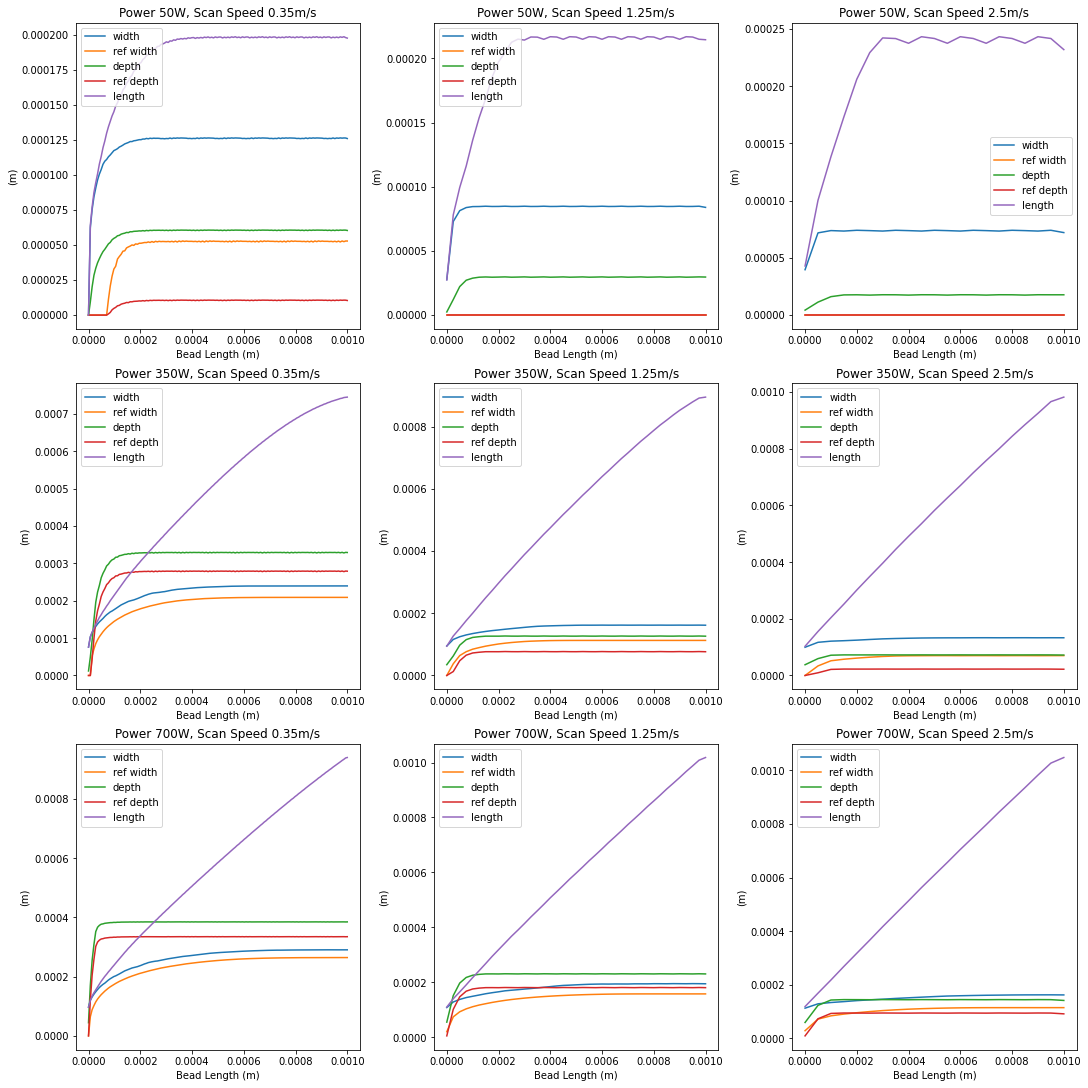

In [9]:
summaries.sort(key=lambda s: (s.input.machine.laser_power, s.input.machine.scan_speed))
nrows = 3
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15), layout="constrained")
for r in range(nrows):
    for c in range(ncols):
        i = r * nrows + c
        mp = summaries[i].melt_pool
        axs[r][c].plot(mp.laser_x, mp.width, label="width")
        axs[r][c].plot(mp.laser_x, mp.reference_width, label="ref width")
        axs[r][c].plot(mp.laser_x, mp.depth, label="depth")
        axs[r][c].plot(mp.laser_x, mp.reference_depth, label="ref depth")
        axs[r][c].plot(mp.laser_x, mp.length, label="length")
        axs[r][c].legend()
        axs[r][c].set_xlabel(f"Bead Length (m)")  # Add an x-label to the axes.
        axs[r][c].set_ylabel(f"(m)")  # Add a y-label to the axes.
        title = (
            "Power "
            + str(summaries[i].input.machine.laser_power)
            + "W, Scan Speed "
            + str(summaries[i].input.machine.scan_speed)
            + "m/s"
        )
        axs[r][c].set_title(title)  # Add a title to the axes.


In [12]:
import numpy as np

powers = []
scan_speeds = []
depth_over_width = []

for s in summaries:
    mp = s.melt_pool
    ave_width = np.average(mp.width)
    ave_depth = np.average(mp.depth)
    powers.append(s.input.machine.laser_power)
    scan_speeds.append(s.input.machine.scan_speed)
    depth_over_width.append(ave_depth / ave_width if ave_width else 0)

In [13]:
print(depth_over_width)

[0.4734114107900323, 0.34108266809815346, 0.2313456365153101, 1.4297059853565557, 0.7929386989032061, 0.546576756299715, 1.4484574309193654, 1.243784058436837, 0.9238980078461269]


Text(0, 0.5, 'Laser Power (w)')

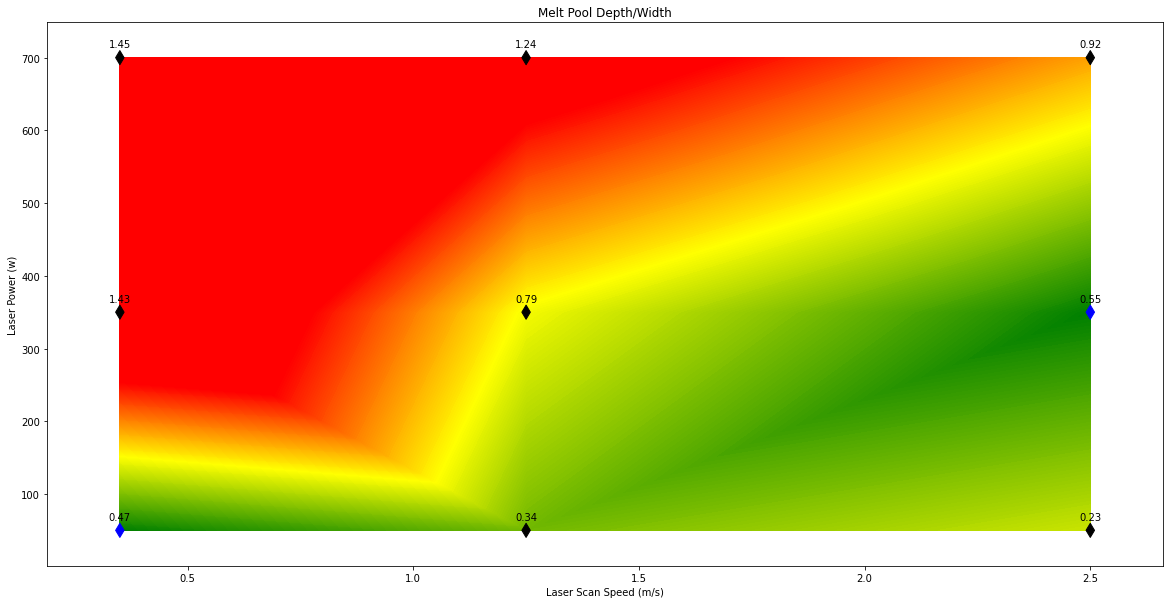

In [17]:
dwMin=0.37
dwMax=0.6
contour_gradient = [] 
marker_colors = []
fig, ax = plt.subplots(figsize=(20,10))
for i in range(len(depth_over_width)):
    if dwMin < depth_over_width[i] < dwMax:
        contour_gradient.append(0)
        marker_colors.append('blue')
    else:
        contour_gradient.append(abs(((dwMax + dwMin) / 2) - depth_over_width[i]))
        marker_colors.append('black')
    txt = "{}".format(round(depth_over_width[i], 2))
    ax.annotate(str(txt), (scan_speeds[i], powers[i] + 25), verticalalignment='top', horizontalalignment='center')

colMap = colorMap.from_list("", ["green", "yellow", "red", "red"])
ax.tricontourf(scan_speeds, powers, contour_gradient, cmap=colMap, levels=255)
ax.scatter(scan_speeds, powers, c=marker_colors, marker='d', s=100, facecolor='none')
ax.use_sticky_edges = False
ax.margins(0.075)
ax.set_title('Melt Pool Depth/Width')
ax.set_xlabel(f'Laser Scan Speed (m/s)')
ax.set_ylabel(f'Laser Power (w)')
